In [1]:
from neo4j import GraphDatabase

url = "bolt://localhost:7687"
username = "neo4j"
password = "letmein"

# Connect to Neo4j
driver = GraphDatabase.driver(url, auth=(username, password))

In [2]:
import pandas as pd

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
run_query("""
MATCH (s1:Stream)-[:SHARED_AUDIENCE]->(s2:Stream)
WITH s1, s2
ORDER BY s1.id,s2.id
WHERE rand() <= 0.9
MERGE (s1)-[:FEATURE_REL]->(s2);
""")

""


In [4]:
# Create test/train rel
# Take the remaining 10%
train_test_size = run_query("""
MATCH (s1)-[:SHARED_AUDIENCE]->(s2)
WHERE NOT (s1)-[:FEATURE_REL]->(s2)
MERGE (s1)-[r:TEST_TRAIN]->(s2)
RETURN count(r) AS result;
""")

print(train_test_size)

   result
0   13094


In [5]:
# Create negative test/train pairs
run_query("""
MATCH (s1:Stream),(s2:Stream)
WHERE NOT (s1)-[:SHARED_AUDIENCE]-(s2) AND s1 < s2
WITH s1,s2
LIMIT $limit
MERGE (s1)-[:NEGATIVE_TEST_TRAIN]->(s2);
""", {"limit": int(train_test_size['result'][0])})

""


# Create features

In [6]:
# Network distance
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
WITH r, length(shortestPath((s1)-[:FEATURE_REL*..6]-(s2))) AS networkDistance
SET r.networkDistance = coalesce(networkDistance, 6)
""")

""


In [7]:
# Preferential attachment
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
WITH r, size((s1)-[:FEATURE_REL]-()) * size((s2)-[:FEATURE_REL]-()) AS preferentialAttachment
SET r.preferentialAttachment = preferentialAttachment
""")


""


In [8]:
# Common neighbors
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH r, count(distinct neighbor) AS commonNeighbor
SET r.commonNeighbor = commonNeighbor
""")

""


In [9]:
# Adamic Adar
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2:Stream)
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH r, collect(distinct neighbor) AS commonNeighbors
UNWIND commonNeighbors AS cn
WITH r, size((cn)-[:FEATURE_REL]-()) AS neighborDegree
WITH r, sum(1 / log(neighborDegree)) AS adamicAdar
SET r.adamicAdar = adamicAdar;
""")

""


In [10]:
# Fetch features
data = run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
WITH r.networkDistance AS networkDistance,
     r.preferentialAttachment AS preferentialAttachment,
     r.commonNeighbor AS commonNeighbor,
     coalesce(r.adamicAdar, 0) AS adamicAdar,
     CASE WHEN r:TEST_TRAIN THEN 1 ELSE 0 END as output
RETURN networkDistance, preferentialAttachment, commonNeighbor, adamicAdar, output     
""")

In [11]:
data.head()

,networkDistance,preferentialAttachment,commonNeighbor,adamicAdar,output
0,2,67988,44,8.260811,1
1,2,93853,99,17.933886,1
2,2,70205,29,5.278815,1
3,2,122674,101,17.878795,1
4,2,113067,133,26.034221,1


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data.drop("output", axis=1)
y = data["output"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2577
           1       0.93      0.92      0.92      2661

    accuracy                           0.92      5238
   macro avg       0.92      0.92      0.92      5238
weighted avg       0.92      0.92      0.92      5238



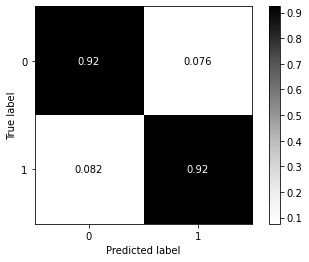

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", cmap="Greys")

In [15]:
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

feature_importance(X.columns, rfc)

,feature,value
0,adamicAdar,0.477387
1,preferentialAttachment,0.261952
2,commonNeighbor,0.258201
3,networkDistance,0.002460
